前面的D，我们学习了37个手写汉字。虽然调整了那个Nerual network的DNN参数，将它们设置为了一样，但是，精度达到80%左右时，就不再提高了。即使后来训练了20多万次，也没什么提高。目前考虑有3种解决方案：
1. 加入validation data (从train中取，还是从test中取？）
2. 对输入的train 数据进行预处理，做翻转、左右、上下平移处理。（加上亮度、透明度处理？）
3. 将DNN改为CNN

理论上讲，应该加上validation。这就象学习后，加入一些小考，然后才是大考。干学不校正，是有问题的。很容易发生过拟合，变成书呆子，适应不了test数据。

在这之前，我们先再尝试修改一下DNN参数，看能否有所改进。
下面第一个模型，参考这里：
https://www.kaggle.com/matlihan/dnn-with-tensorflow-s-dataset-api-and-estimator

```
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns, # The input features to our model
    hidden_units=[2048, 1024, 512, 256, 128], # 5 layers
    n_classes=2, # survived or not {1, 0}
    model_dir=save_dir, # Path to where checkpoints etc are stored
    optimizer=tf.train.RMSPropOptimizer(
        learning_rate=0.00001),
    dropout=0.1)


```

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
from numpy import array

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize

IMAGE_SIZE = 64
FULL_CHARSET_SIZE = 3755
CHARSET_SIZE = 37

def input(dataset):
    return dataset.images, dataset.labels

class DataSetLoader:
    def __init__(self, data_dir):
        # Set CHARSET_SIZE to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print('Now processing path: ', truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        self.images = [rgb2gray(item) for item in image_resized]
        
        # convert list to numpy array
        self.images = array(self.images)
        self.labels = array(self.labels)
    
train_data = DataSetLoader(data_dir='../data/train_/')
print ('Train data loaded.')

# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[IMAGE_SIZE, IMAGE_SIZE])]

# Build 8 layer DNN classifier
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns, # The input features to our model
    hidden_units=[4096, 4096, 4096, 4096, 4096, 4096], # 6 hidden layers
    n_classes=CHARSET_SIZE, # survived or not {1, 0}
    model_dir="../dfs/checkpoint/dnn8_model_a", # Path to where checkpoints etc are stored
    optimizer=tf.train.RMSPropOptimizer(
        learning_rate=0.00001),
    dropout=0.1)

# Define the training inputs
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(train_data)[0]},
    y=input(train_data)[1],
    num_epochs=None,
    batch_size=50,
    shuffle=True
)

classifier.train(input_fn=train_input_fn, steps=10000)
print ('Train done, begin to test ...')
test_data = DataSetLoader(data_dir='../data/test_/')
# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    y=input(test_data)[1],
    num_epochs=1,
    shuffle=False
)

# Evaluate accuracy
accuracy_score = classifier.evaluate(input_fn=test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

Now processing path:  ../data/train_/00037
Train data loaded.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../dfs/checkpoint/dnn8_model_a', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn8_model_a/model.ckpt-64775
INFO:tensorflow:Saving checkpoints for 64776 into ../dfs/checkpoint/dnn8_model_a/model.ckpt.
INFO:tensorflow:loss = 0.0103052, step = 64776
INFO:tensorflow:global_step/sec: 0.862684
INFO:tensorflow:loss = 0.00044283, step = 64876 (115.920 sec)
INFO:tensorflow:global_step/sec: 0.799325
INFO:tensorflow:loss = 4.87563e-05, step = 64976 (125.116 sec)


改为6层DNN，学得超快无比：
INFO:tensorflow:Saving checkpoints for 1 into ../dfs/checkpoint/dnn8_model_a/model.ckpt.
INFO:tensorflow:loss = 184.751, step = 1
INFO:tensorflow:global_step/sec: 1.60653
INFO:tensorflow:loss = 180.424, step = 101 (62.248 sec)
INFO:tensorflow:global_step/sec: 1.6572
INFO:tensorflow:loss = 175.846, step = 201 (60.342 sec)
INFO:tensorflow:global_step/sec: 1.66683
INFO:tensorflow:loss = 156.408, step = 301 (59.994 sec)
INFO:tensorflow:global_step/sec: 1.65212
INFO:tensorflow:loss = 133.999, step = 401 (60.530 sec)
INFO:tensorflow:global_step/sec: 1.69154
INFO:tensorflow:loss = 121.082, step = 501 (59.117 sec)

快不是运行速度，是学习速度；几百步，loss就从180多降到120多。最初的模型，上千步时，loss还在180时左右徘徊。
感觉层数与层里的节点数，就像大脑的容量；越大真的越强。

下面是手工测试：

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdbc9960588>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../dfs/checkpoint/dnn8_model_a'}
Now processing path:  ../data/test_/00037
INFO:tensorflow:Starting evaluation at 2018-04-23-00:58:04
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn8_model_a/model.ckpt-64775
INFO:tensorflow:Finished evaluation at 2018-04-23-00:58:11
INFO:tensorflow:Saving dict for global step 64775: accuracy = 0.831674, average_loss = 1.55298,

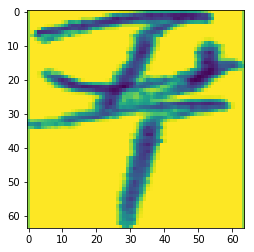

Prediction label is:  22
Real label is: 22


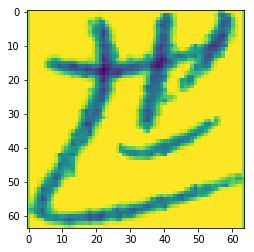

Prediction label is:  13
Real label is: 13


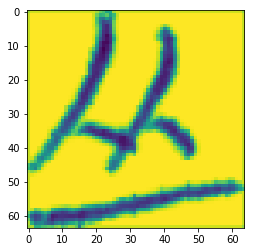

Prediction label is:  17
Real label is: 17


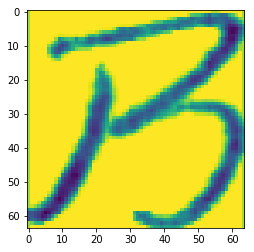

Prediction label is:  36
Real label is: 36


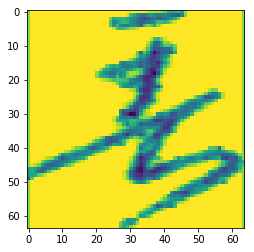

Prediction label is:  27
Real label is: 20


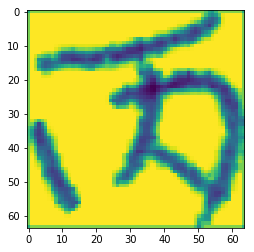

Prediction label is:  15
Real label is: 15


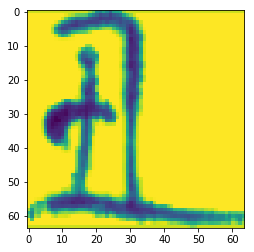

Prediction label is:  10
Real label is: 10


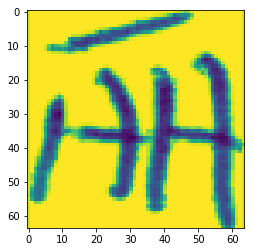

Prediction label is:  34
Real label is: 34


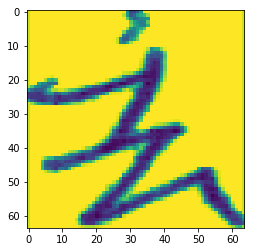

Prediction label is:  20
Real label is: 20


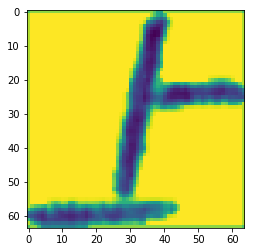

Prediction label is:  6
Real label is: 6


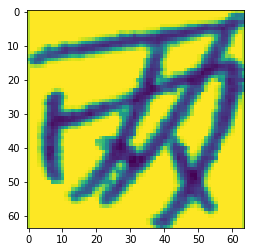

Prediction label is:  30
Real label is: 21


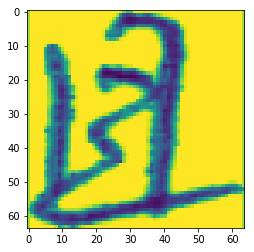

Prediction label is:  12
Real label is: 12


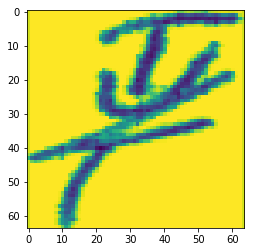

Prediction label is:  22
Real label is: 22


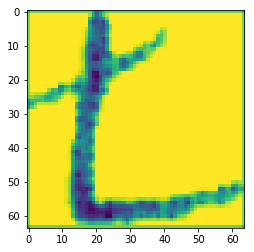

Prediction label is:  2
Real label is: 2


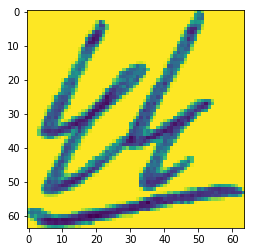

Prediction label is:  19
Real label is: 19


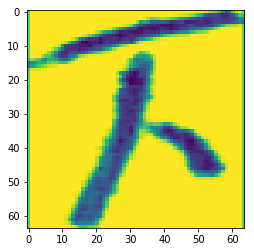

Prediction label is:  7
Real label is: 7


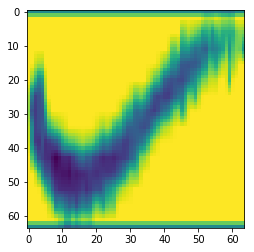

Prediction label is:  0
Real label is: 0


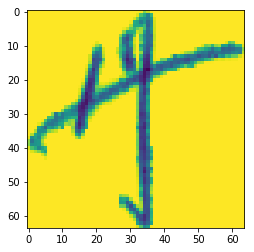

Prediction label is:  24
Real label is: 31


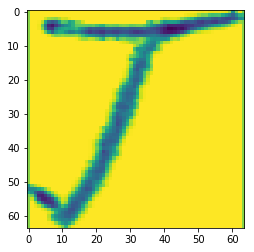

Prediction label is:  1
Real label is: 1


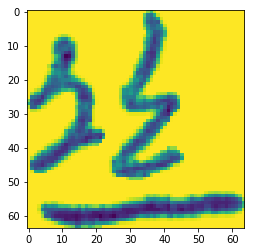

Prediction label is:  19
Real label is: 19


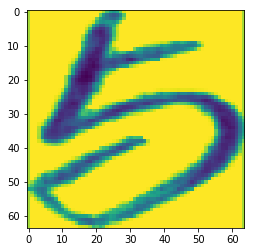

Prediction label is:  9
Real label is: 9


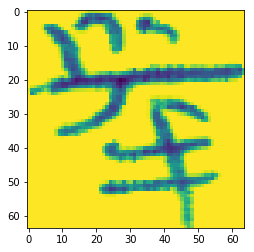

Prediction label is:  35
Real label is: 35


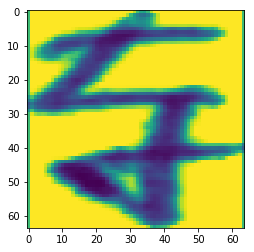

Prediction label is:  18
Real label is: 18


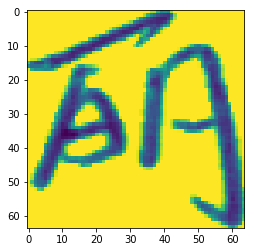

Prediction label is:  34
Real label is: 34


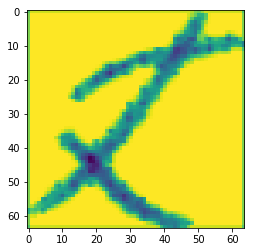

Prediction label is:  4
Real label is: 4


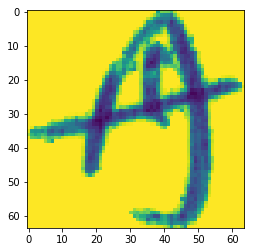

Prediction label is:  31
Real label is: 31


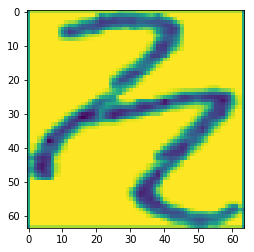

Prediction label is:  8
Real label is: 3


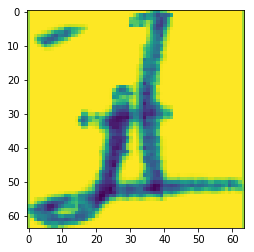

Prediction label is:  14
Real label is: 10


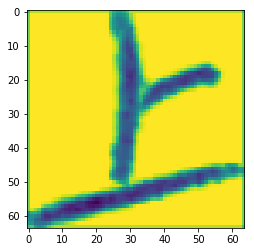

Prediction label is:  6
Real label is: 6


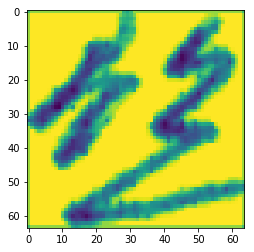

Prediction label is:  19
Real label is: 19


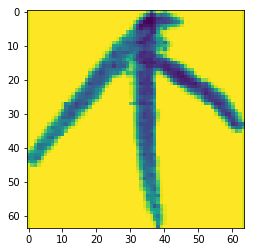

Prediction label is:  27
Real label is: 24


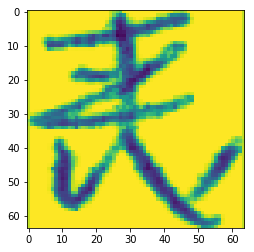

Prediction label is:  10
Real label is: 23


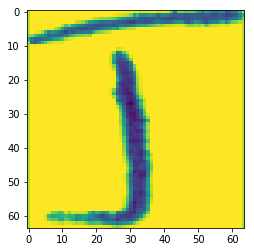

Prediction label is:  1
Real label is: 1


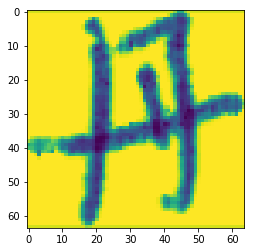

Prediction label is:  31
Real label is: 31


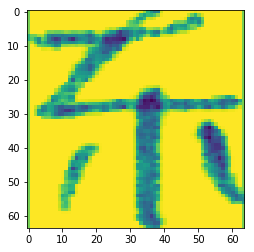

Prediction label is:  18
Real label is: 18


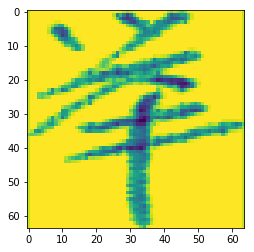

Prediction label is:  35
Real label is: 35


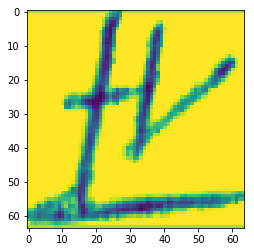

Prediction label is:  16
Real label is: 16


In [6]:
# from: https://www.kaggle.com/jeffcarp/example-save-and-load-a-tensorflow-model

import tensorflow as tf
import numpy as np
import os
import random
from numpy import array

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize

from tensorflow.contrib.learn.python.learn.estimators import run_config
from tensorflow.contrib.training.python.training import hparam

IMAGE_SIZE = 64
# CHARSET_SIZE = 3755
CHARSET_SIZE = 37

def input(dataset):
    return dataset.images, dataset.labels

class DataSetLoader:
    def __init__(self, data_dir):
        # Set CHARSET_SIZE to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print('Now processing path: ', truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        self.images = [rgb2gray(item) for item in image_resized]
        
        # convert list to numpy array
        self.images = array(self.images)
        self.labels = array(self.labels)

# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[IMAGE_SIZE, IMAGE_SIZE])]

def make_estimator(model_dir):
    config = run_config.RunConfig(model_dir=model_dir)

    return tf.estimator.DNNClassifier (
        config=config,
        feature_columns=feature_columns, # The input features to our model
    hidden_units=[4096, 4096, 4096, 4096, 4096, 4096], # 6 hidden layers
    n_classes=CHARSET_SIZE, # survived or not {1, 0}
    optimizer=tf.train.RMSPropOptimizer(
        learning_rate=0.00001),
    dropout=0.1)
    

MODEL_DIR = "../dfs/checkpoint/dnn8_model_a"
model_from_checkpoint = make_estimator(MODEL_DIR)

test_data = DataSetLoader(data_dir='../data/test_/')
# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    y=input(test_data)[1],
    num_epochs=1,
    shuffle=False
)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    num_epochs=1,
    shuffle=False)

# Evaluate accuracy
accuracy_score = model_from_checkpoint.evaluate(input_fn=test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

# manually test
predictions = list(model_from_checkpoint.predict(input_fn=predict_input_fn))
predictions_value_array = list(predictions)

import matplotlib.pyplot as plt

def test_n_hanzi(predictions_values, index):
    # Show the image of the input data
    image_data_array = test_data.images[index]
    image_data = image_data_array.reshape((IMAGE_SIZE, IMAGE_SIZE))
    plt.imshow(image_data)
    plt.show()
    
    # show the prediction result
    print ('Prediction label is: ', np.argmax(predictions_values[index]["probabilities"]))
    
    # Show the lable
    print ("Real label is: %d"%(test_data.labels[index]))

for i in range(37):
    test_n_hanzi(predictions_value_array, i)    



INFO:tensorflow:Starting evaluation at 2018-04-21-11:03:02
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn8_model_a/model.ckpt-24775
INFO:tensorflow:Finished evaluation at 2018-04-21-11:03:08
INFO:tensorflow:Saving dict for global step 24775: accuracy = 0.826244, average_loss = 1.14508, global_step = 24775, loss = 140.59

Test Accuracy: 82.624435%
    
    这个训练时间长，2万多步时，精度为82%。用了8个小时。
    
    再来一次看看。
    
INFO:tensorflow:Starting evaluation at 2018-04-22-01:18:01
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn8_model_a/model.ckpt-44775
INFO:tensorflow:Finished evaluation at 2018-04-22-01:18:07
INFO:tensorflow:Saving dict for global step 44775: accuracy = 0.841176, average_loss = 1.29896, global_step = 44775, loss = 159.483

Test Accuracy: 84.117645%

这个有进步。

再来1万步，精度下降了：
INFO:tensorflow:Starting evaluation at 2018-04-22-06:09:30
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn8_model_a/model.ckpt-54775
INFO:tensorflow:Finished evaluation at 2018-04-22-06:09:41
INFO:tensorflow:Saving dict for global step 54775: accuracy = 0.825792, average_loss = 1.48392, global_step = 54775, loss = 182.192

Test Accuracy: 82.579184%


再来一万步看看：（14：10开始：）

INFO:tensorflow:Starting evaluation at 2018-04-23-00:58:04
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn8_model_a/model.ckpt-64775
INFO:tensorflow:Finished evaluation at 2018-04-23-00:58:11
INFO:tensorflow:Saving dict for global step 64775: accuracy = 0.831674, average_loss = 1.55298, global_step = 64775, loss = 190.671

Test Accuracy: 83.167422%

INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn8_model_a/model.ckpt-64775

这个有也进步！
